<a href="https://colab.research.google.com/github/OIEIEIO/Q-bits/blob/main/using_primitives_belem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

Submitting user-transpiled circuits using primitives

---



In [ ]:
!pip install qiskit

In [ ]:
!pip install qiskit-ibm-runtime

In [ ]:
!pip install pylatexenc

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum', token='use you IBM quantum API token')

service = QiskitRuntimeService()



---

Transpiling circuits for IBM Quantum devices

---



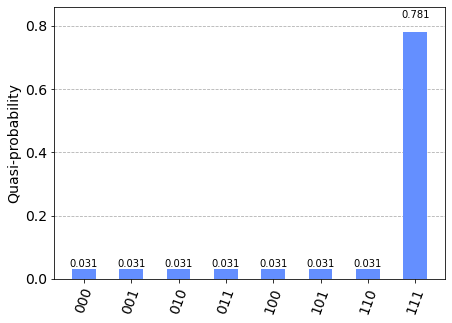

In [5]:
# Create circuit to test transpiler on
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, Diagonal
oracle = Diagonal([1]*7 + [-1])
qc = QuantumCircuit(3)
qc.h([0,1,2])
qc = qc.compose(GroverOperator(oracle))

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

from qiskit.visualization import plot_histogram
plot_histogram(ideal_distribution)

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

service = QiskitRuntimeService()
backend = service.backend('ibmq_belem')

# Need to add measurements to the circuit
qc.measure_all()

from qiskit import transpile
circuits = []
for optimization_level in [0, 3]:
    t_qc = transpile(qc,
                     backend,
                     optimization_level=optimization_level,
                     seed_transpiler=0)
    print(f'CNOTs (optimization_level={optimization_level}): ',
          t_qc.count_ops()['cx'])
    circuits.append(t_qc)

CNOTs (optimization_level=0):  27
CNOTs (optimization_level=3):  14


In [7]:
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ASAPSchedule, DynamicalDecoupling
from qiskit.circuit.library import XGate

# Get gate durations so the transpiler knows how long each operation takes
durations = InstructionDurations.from_backend(backend)

# This is the sequence we'll apply to idling qubits
dd_sequence = [XGate(), XGate()]

# Run scheduling and dynamic decoupling passes on circuit
pm = PassManager([ASAPSchedule(durations),
                  DynamicalDecoupling(durations, dd_sequence)]
                )
circ_dd = pm.run(circuits[1])

# Add this new circuit to our list
circuits.append(circ_dd)

Run user-transpiled circuits using Qiskit Runtime

In [8]:
from qiskit_ibm_runtime import Sampler

with Sampler(circuits=circuits, service=service,
             options={'backend': backend},
             skip_transpilation=True) as sampler:
    result = sampler(
        circuits=[0,1,2],  # sample all three circuits
        shots=8000
    )

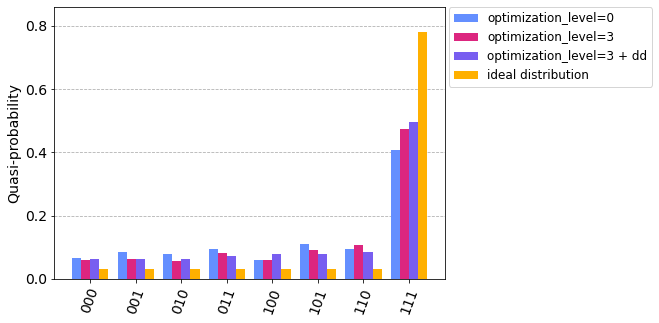

In [9]:
from qiskit.visualization import plot_histogram
plot_histogram(result.quasi_dists+[ideal_distribution],
               bar_labels=False,
               legend=['optimization_level=0',
                       'optimization_level=3',
                       'optimization_level=3 + dd',
                       'ideal distribution'])

In [10]:
from qiskit.quantum_info import hellinger_fidelity
for counts in result.quasi_dists:
    print(
        f"{hellinger_fidelity(counts, ideal_distribution):.3f}"
    )

0.850
0.894
0.910


In [11]:
import qiskit_ibm_runtime
qiskit_ibm_runtime.version.get_version_info()

'0.6.2'

In [12]:
from qiskit.tools.jupyter import *
%qiskit_version_table
%qiskit_copyright